# Импорты

In [20]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve

from src import preprocess

import matplotlib.pyplot as plt

import joblib

# Загрузка данных

In [2]:
train = pd.read_parquet('./data/train.parquet', engine='pyarrow')
test = pd.read_parquet('./data/test.parquet', engine='pyarrow')

In [3]:
train = preprocess.preprocess(train)

d:\Projects\vk_ds_intership\src\preprocess.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['std'] = features['values'].apply(np.std)
d:\Projects\vk_ds_intership\src\preprocess.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['min'] = features['values'].apply(np.min)
d:\Projects\vk_ds_intership\src\preprocess.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [5]:
train.head()

,id,label,mean,std,min,max,sum,range,diff,std_diff,q25,q75,rolling_mean_3,rolling_std_3
0,19114,0.0,0.023710,1.337272,-4.840000,3.49,1.470000,8.330000,1.290000,1.993975,-0.6825,0.7700,0.049944,1.166370
1,22769,1.0,-0.310777,1.556337,-3.534409,2.92,-13.984957,6.454409,0.985591,2.000644,-1.0400,0.7100,-0.277842,1.290425
2,76935,0.0,-0.046042,1.065023,-1.950000,2.61,-2.210000,4.560000,-0.700000,1.073534,-0.8775,0.6150,-0.050435,0.676482
3,66297,0.0,-0.130000,1.158201,-2.220000,2.49,-6.240000,4.710000,1.920000,0.888266,-0.9500,0.8250,-0.167101,0.565971
4,2191,0.0,-0.270536,1.270529,-2.500000,2.87,-15.150000,5.370000,-2.060000,1.717244,-1.2500,0.6775,-0.275123,1.149014


In [6]:
X = train.drop(['id', 'label'], axis=1, errors='ignore')
y = train.label

In [9]:
len(y[y==1]) / len(y)

0.27689208128941833

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

# RF

In [11]:
rf = RandomForestClassifier()


In [17]:
param_distributions = {
    'n_estimators': [50, 100, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(estimator=rf,
                                    param_distributions=param_distributions,
                                    n_iter=20,
                                    cv=3,
                                    scoring='roc_auc',
                                    verbose=2,
                                    random_state=42,
                                    n_jobs=10,
                                    return_train_score=True)

random_search.fit(X_train, y_train)

mean_train_auc = random_search.cv_results_['mean_train_score']
mean_test_auc = random_search.cv_results_['mean_test_score']

Fitting 3 folds for each of 20 candidates, totalling 60 fits


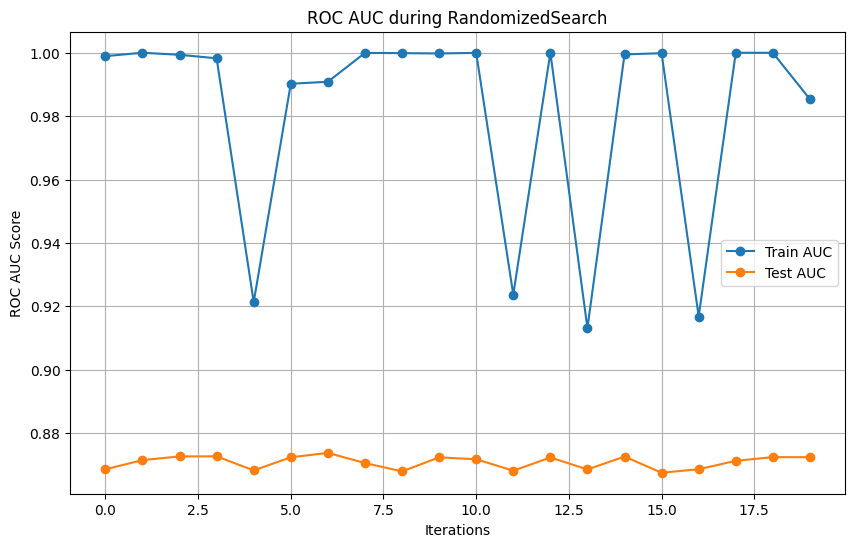

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(mean_train_auc, label='Train AUC', marker='o')
plt.plot(mean_test_auc, label='Test AUC', marker='o')
plt.title('ROC AUC during RandomizedSearch')
plt.xlabel('Iterations')
plt.ylabel('ROC AUC Score')
plt.legend()
plt.grid()
plt.show()

In [21]:
best_rf_random = random_search.best_estimator_

In [39]:
joblib.dump(best_rf_random, './models/best_RF_model.pkl')

['./models/best_RF_model.pkl']

# XGB

In [29]:
xgb_model = xgb.XGBClassifier(eval_metric='logloss')

In [30]:
# Определение параметров для RandomizedSearch
param_distributions = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': np.random.randint(low=1, high=15, size=7),
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.5, 0.75, 1.0],
    'colsample_bytree': [0.3, 0.5, 0.7],
    'gamma': [0, 0.1, 0.2, 0.3]
}

random_search = RandomizedSearchCV(estimator=xgb_model,
                                    param_distributions=param_distributions,
                                    n_iter=20,
                                    cv=3,
                                    scoring='roc_auc',
                                    verbose=2,
                                    random_state=42,
                                    n_jobs=10,
                                    return_train_score=True)

random_search.fit(X_train, y_train)

best_xgb_random = random_search.best_estimator_
print("Лучшие гиперпараметры RandomizedSearch:", random_search.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Лучшие гиперпараметры RandomizedSearch: {'subsample': 0.5, 'n_estimators': 200, 'max_depth': np.int32(5), 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.7}


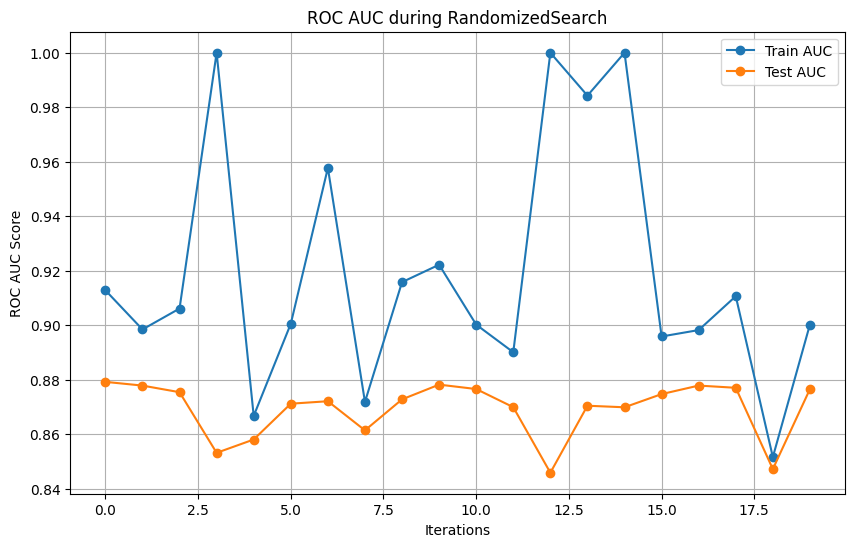

In [31]:
mean_train_auc = random_search.cv_results_['mean_train_score']
mean_test_auc = random_search.cv_results_['mean_test_score']
plt.figure(figsize=(10, 6))
plt.plot(mean_train_auc, label='Train AUC', marker='o')
plt.plot(mean_test_auc, label='Test AUC', marker='o')
plt.title('ROC AUC during RandomizedSearch')
plt.xlabel('Iterations')
plt.ylabel('ROC AUC Score')
plt.legend()
plt.grid()
plt.show()

In [32]:
joblib.dump(best_xgb_random, './models/best_XGB_model.pkl')

['./models/best_XGB_model.pkl']

In [35]:
xgb_preds_test = best_xgb_random.predict_proba(X_test)[:, 1]
rf_preds_test = best_rf_random.predict_proba(X_test)[:, 1]

In [37]:
roc_auc_score(y_true=y_test, y_score=xgb_preds_test), roc_auc_score(y_true=y_test, y_score=xgb_preds_test)

(np.float64(0.8774043825529143), np.float64(0.8774043825529143))